<font size="20"> Prediction of Heart Disease </font>

<font size="4"> Group: Christina Z, Abeer I, Adiba C, Renee C. </font>

<font size="5"> Introduction </font>




   Heart disease has been the leading cause of death in many countries (Namara et. al, 2022). High blood pressure is one of the main risk factors for heart disease among various others. With high blood pressure, the heart arteries become damaged by elasticity loss, which decreases the flow of blood to heart and leads to a heart disease (Fuchs et.al, 2020). Sex difference is also found to be a risk factor since scientists had proved that the associations between high blood pressure and heart disease were not equivalent in women and men (Colafella et.al, 2018). From this knowledge, we came up with a predictive question: what is the likelihood of developing heart disease based on blood pressure and sex? 

   We are going to use classification with K-nearest neighbors to answer our predictive question. The dataset we used contains 14 patient attributes which are relevant to the heart disease: age, sex, chest pain, resting blood pressure, …, and heart disease diagnosis. We will use sex, blood pressure and heart disease diagnosis to answer this question. 


<font size="5"> Preliminary Exploratory Data Analysis </font>

For the first step, we will  install the packages containing the functions needed to perform our data analysis. Next, we loaded in the data and renamed the columns into a readable form.

In [ ]:
install.packages("tidymodels")
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read.csv(file = url) |>
rename(age=X63.0,
       sex=X1.0,
       chest_pain=X1.0.1,
       resting_blood_pressure=X145.0,
       cholesterol=X233.0,
       fasting_blood_sugar=X1.0.2,
       resting_electrocardiographic_results=X2.0,
       max_heart_rate=X150.0,
       exercise_induced_angina=X0.0,
       S_depression_induced=X2.3,
       slope_of_peak_exercise=X3.0,
       major_vessels=X0.0.1,
       thal=X6.0,
       heart_disease_diagnosis=X0)
heart_data 


Next, we split our data into two parts: training and testing data. We used prop=0.75 in order to have 75% as training data and 25% as testing data. 

In [2]:
set.seed(20)
heart_split <- initial_split(heart_data, prop=0.75, strata=resting_blood_pressure)
    heart_train <- training(heart_split)
    heart_test <- testing(heart_split)


Since we have decided on focusing on the factors sex and resting blood pressure to predict heart disease, we therefore selected these two columns in the code below to further carry out the preliminary data analysis. 

In [3]:
heart_train_selected <- select(heart_train, sex, resting_blood_pressure, heart_disease_diagnosis) |>
                        arrange(sex, resting_blood_pressure) 
heart_train_selected

sex,resting_blood_pressure,heart_disease_diagnosis
<dbl>,<dbl>,<int>
0,94,0
0,102,0
0,105,0
⋮,⋮,⋮
1,172,0
1,178,0
1,180,3


Table 1:
This table shows the number of rows with missing data (NA's). As seen below, there are zero rows with missing data. We further confirm this by finding the total number of rows in the heart train dataset and the number of rows after removing for any missing rows. We find that both report 224 rows. This confirms that there are no rows with missing data in this dataset. 

In [4]:
heart_train %>%
map_df(is.na) %>%
map_df(sum)

age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
nrow(heart_train)
nrow(heart_train %>% na.omit())

[1] 224

[1] 224

Table 2:
This table reports the number of observations for each class. It is found that there is the greatest amount of observations 
found for the heart disease diagnosed as 0 and the least amount of observations for the heart disease diagnosed as 4.

In [6]:
count <- group_by(heart_train_selected, heart_disease_diagnosis) |>
            summarize(total=n())
count

heart_disease_diagnosis,total
<int>,<int>
0,120
1,41
2,22
3,28
4,13


In [7]:
#Table 3:
#The table below reports the average heart disease diagnosis (on a scale of 0-4) for males(1) and females(0).
#It is found that the heart disease diagnosis level is slightly greater for males (~1.03) compared to females (~0.51).
sex_vs_heart_disease <- group_by(heart_train_selected, sex) |>
                        summarize(heart_disease_diagnosis=mean(heart_disease_diagnosis, na.rm=TRUE))
sex_vs_heart_disease

sex,heart_disease_diagnosis
<dbl>,<dbl>
0,0.5882353
1,1.1602564


In [8]:
#Table 4:
#The table below reports the average resting blood pressure (mm Hg) for each heart disease diagnosis level (0-4). 
#There is generally a slight increase in resting blood pressure as the heart disease diagnosis level increases. 
heart_disease_vs_resting_blood_pressure <- group_by(heart_train_selected, heart_disease_diagnosis) |>
                                summarize(resting_blood_pressure=mean(resting_blood_pressure, na.rm=TRUE))
heart_disease_vs_resting_blood_pressure

heart_disease_diagnosis,resting_blood_pressure
<int>,<dbl>
0,128.9250
1,133.1951
2,135.7727
3,132.9286
4,138.7692


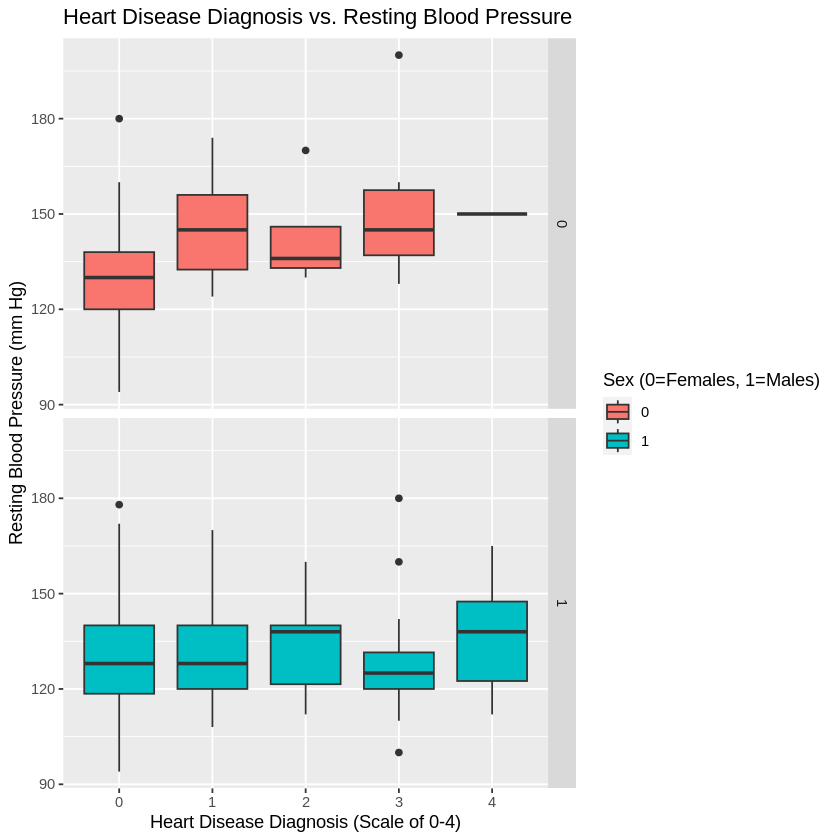

In [9]:
#Graph 1:
#Plot of heart disease diagnosis on a scale of 0-4 versus resting blood pressure (mm Hg) in men and women. 
#The graph shows that heart disease diagnosis level has a weak positive correlation with resting blood pressure for 
#both male (1) and female (0). 
#An increase in the heart disease diagnosis level correlates to a slight increase in resting blood pressure amount.
#There is a stronger relationship between heart disease diagnosis and resting blood pressure for males, but also  
#more outliers in the data. 
plot_heart_disease_vs_resting_blood_pressure <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            mutate(sex = as.factor(sex)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=resting_blood_pressure, fill=sex)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Resting Blood Pressure (mm Hg)", fill= "Sex (0=Females, 1=Males)", title="Heart Disease Diagnosis vs. Resting Blood Pressure", )+
                            facet_grid(sex~.) 
plot_heart_disease_vs_resting_blood_pressure

For our project, we are more interested in finding out whether or not heart disease is present in an individual, rather than the level of heart disease severity (0, 1, 2, 3, 4). Therefore, we grouped all heart disease diagnosis levels of 0 into one group (represented by 0) and we grouped all heart disease diagnosis levels of 1, 2, 3, and 4, into one group into one group (represented by 1). The group represented by 0 indicates no heart disease present, while the group represented by 1 indicates the presence of heart disease. This new column will be titled new_heart_binary.

In [10]:
heart_train_grouped <- heart_train |>
                        mutate(new_heart_binary=ifelse(heart_disease_diagnosis %in% c(1, 2, 3, 4), 1, 0)) |>
                        mutate(new_heart_binary = as.factor(new_heart_binary)) 

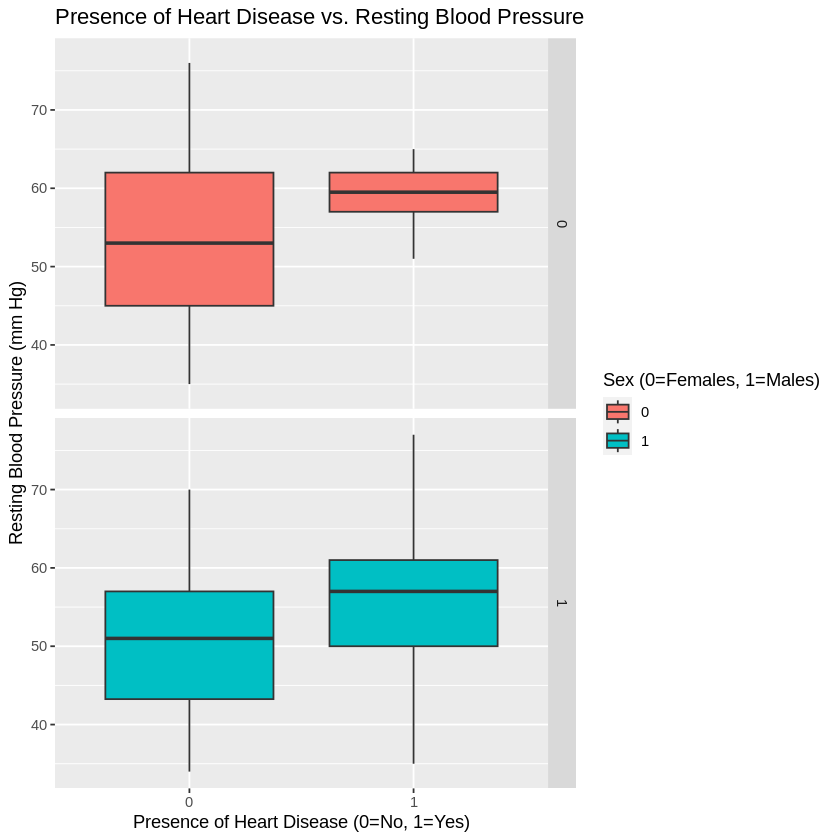

In [11]:
#Graph 2: 
#Plot of the presence of heart disease (with 0 indicating no heart disease and 1 indicating the presence of heart 
#disease) versus the resting blood pressure level (in mm Hg). From this graph, we can more easily see a correlation.
#The presence of heart disease is correlated with a higher median resting blood pressure level (~6 mm Hg increase) 
#compared to no presence of heart disease for both male (1) and female (0). Males (1) have generally a lower 
#resting blood pressure as compared to females (0). 

plot_heart_disease_vs_resting_blood_pressure <- heart_train_grouped |>
                            mutate(sex = as.factor(sex)) |>
                            ggplot(aes(x=new_heart_binary, y=age, fill=sex)) +
                                 geom_boxplot() +
                                 labs(x="Presence of Heart Disease (0=No, 1=Yes)", y="Resting Blood Pressure (mm Hg)", fill="Sex (0=Females, 1=Males)", title="Presence of Heart Disease vs. Resting Blood Pressure", )+
                            facet_grid(sex~.)
plot_heart_disease_vs_resting_blood_pressure

Even though we usually would not touch the testing data, in this instance we need to perform this grouping for both the training and testing data to ensure that the heart diagnosis is grouped in the same manner for both. If we do not do this, then when we try and test the model, the predictions will not be accurate since it would be on a different scale.

In [12]:
heart_test_grouped <- heart_test |>
                        mutate(new_heart_binary=ifelse(heart_disease_diagnosis %in% c(1, 2, 3, 4), 1, 0)) |>
                        mutate(new_heart_binary = as.factor(new_heart_binary)) 

<font size="5"> Methods </font>

We will create a summary table to predict whether heart disease diagnosis is affected by the factors. The original data set is quite tidy but not all the data is relevant. Therefore we use select() to create a table with relevant data(blood pressure, sex and heart disease diagnosis). Next, we will create a visualisation plot. We will make a box-plot and use facet_grid() to create visualisation plots that show how the factors interact for each gender on top of each other. 

To create the model we will split our dataset into training and testing dataset, setting aside the test dataset until the end to test our model. The training dataset will be further broken up into validation and training set 5 times (5-fold cross validation). Then, we will create a plot of accuracy versus k value to ensure we pick the k-value with the highest accuracy to ensure our model is as accurate as possible. We will use k-nearest-neighbour and use the two factors as the predictors and predict whether heart disease is present or not.


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5447475,5,0.007269219,Preprocessor1_Model01
1,roc_auc,binary,0.5451190,5,0.003886864,Preprocessor1_Model01
2,accuracy,binary,0.5266667,5,0.017069213,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,roc_auc,binary,0.6391071,5,0.01569902,Preprocessor1_Model24
25,accuracy,binary,0.5710101,5,0.02854121,Preprocessor1_Model25
25,roc_auc,binary,0.6366468,5,0.01074353,Preprocessor1_Model25


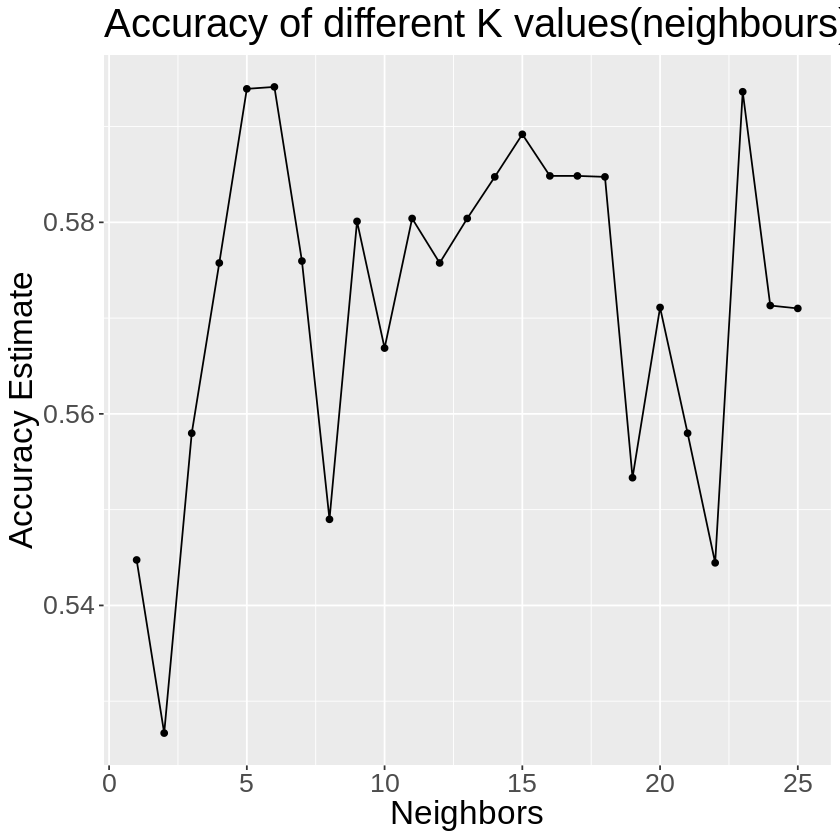

In [13]:
set.seed(20)
#set seed to ensure we are using the same randomised numbers

heart_vfold <- vfold_cv(heart_train_grouped, v = 5, strata = new_heart_binary)

heart_recipe <- recipe(new_heart_binary ~ resting_blood_pressure + sex, data = heart_train_grouped) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors=seq(from=1, to=25, by=1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()
knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy of different K values(neighbours)") +
    theme(text = element_text(size = 20))
cross_val_plot


In [14]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = heart_train_grouped)

heart_predictions <- predict(heart_fit, heart_test_grouped) |> 
    bind_cols(heart_test_grouped)

# Compare the accuracy of predictions to the true values in the test set
heart_acc <- heart_predictions |> 
    metrics(truth = new_heart_binary, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
heart_acc

# Compare the predictions to the true values in a confusion matrix
heart_cm <- heart_predictions |> 
    conf_mat(truth = new_heart_binary, estimate = .pred_class)
heart_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.6538462


          Truth
Prediction  0  1
         0 28 12
         1 15 23

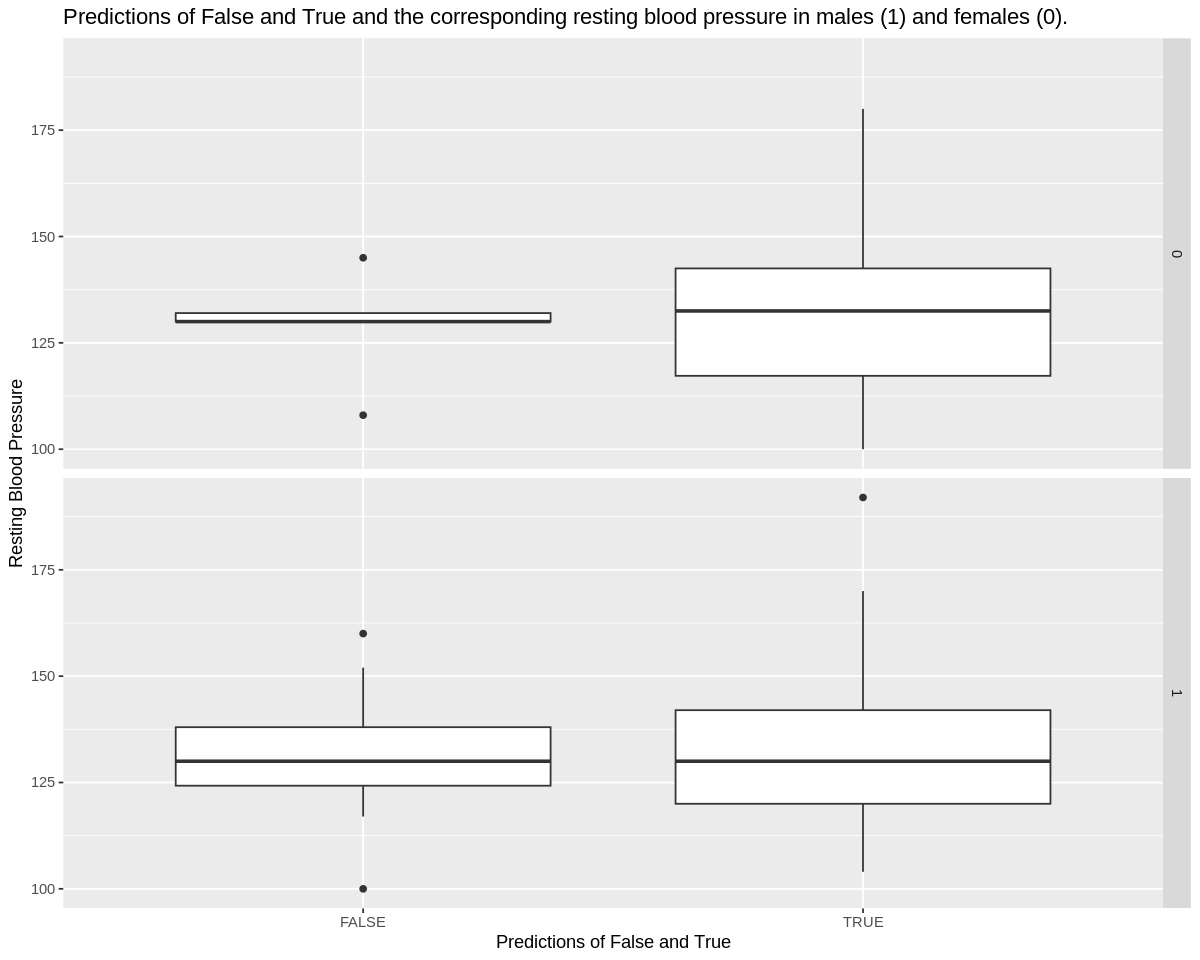

In [15]:
#Figure 1: Predictions of False and True and the corresponding resting blood pressure in males (1) and females (0).
#This figure shows that our data is unbiased since the the median value (horizontal line) for both True and False predictions 
#are generally the same for both males (1) and females (0). 

options(repr.plot.width = 10, repr.plot.height = 8)

new_heart_predictions <- heart_predictions |>
        mutate(is_accurate = .pred_class == new_heart_binary) 
        
heart_plot_2 <- new_heart_predictions |>
        ggplot()+
        geom_boxplot(aes(x = is_accurate, y = resting_blood_pressure))+
        facet_grid(as.factor(sex)~.) +
        labs(x="Predictions of False and True", y="Resting Blood Pressure") +
        ggtitle("Predictions of False and True and the corresponding resting blood pressure in males (1) and females (0).")
heart_plot_2


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,is_accurate,count,prop
<dbl>,<lgl>,<int>,<dbl>
0,FALSE,5,0.1724138
0,TRUE,24,0.8275862
1,FALSE,22,0.4489796
1,TRUE,27,0.5510204


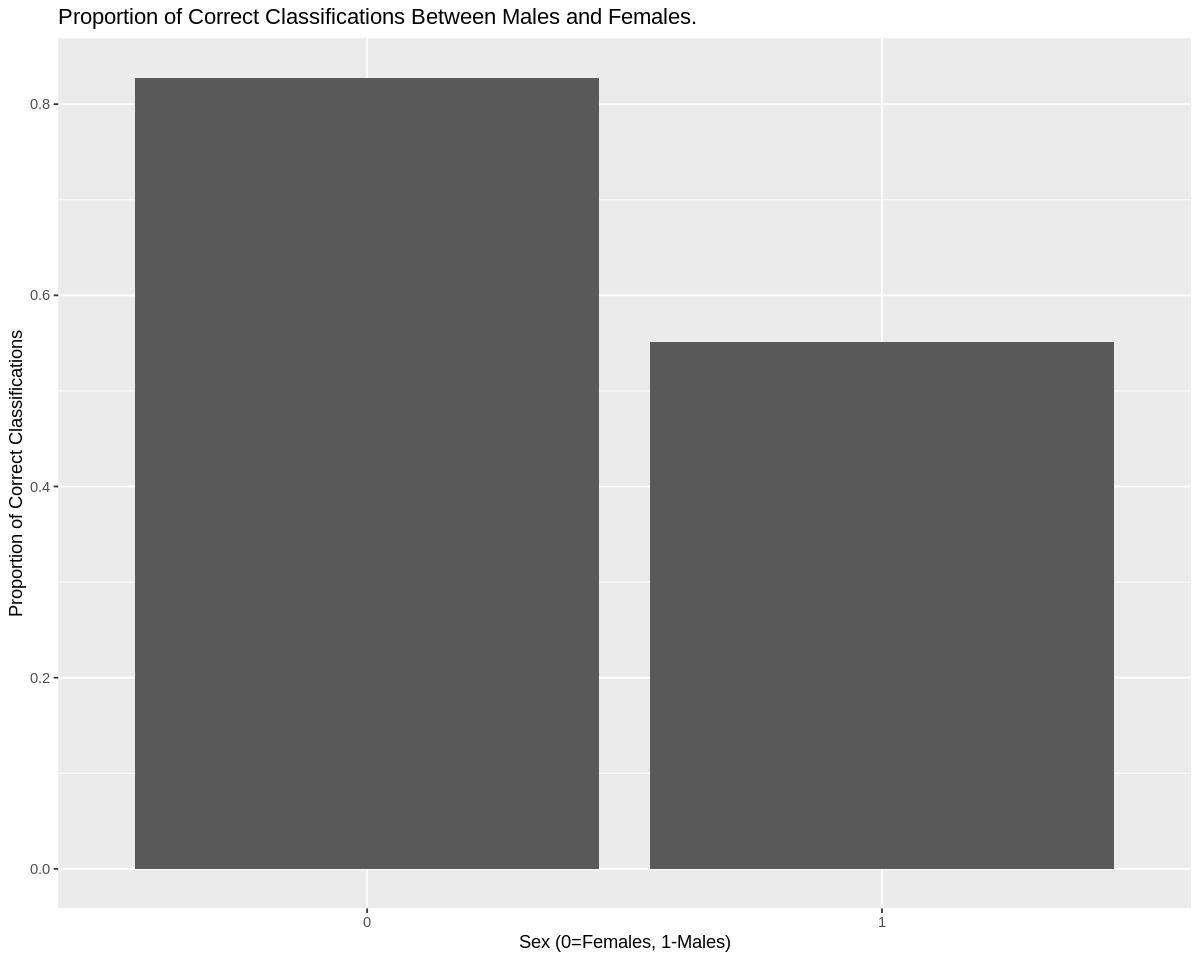

In [16]:
#Figure 2: Proportion of correct classifications between male and females.
#This bar graph shows that there is a higher accuracy for females (~85%) as compared to males (~55%).
Count <- new_heart_predictions |>
        group_by(sex, is_accurate) |>
        summarize(count=n()) |>
        mutate(prop = count/sum(count))

Count
Count |>
filter(is_accurate == TRUE) |>
ggplot()+
    geom_bar(aes(x = as.factor(sex), y = prop), stat = "identity") +
    labs(x="Sex (0=Females, 1-Males)", y="Proportion of Correct Classifications") +
    ggtitle("Proportion of Correct Classifications Between Males and Females.")


In [17]:
Count <- new_heart_predictions |>
        mutate(resting_blood_pressure_grouped = ifelse(resting_blood_pressure <= 90, "Low", ifelse(resting_blood_pressure >=120, "High", "Normal"))) |>
        mutate(resting_blood_pressure_grouped = as.factor(resting_blood_pressure_grouped)) |>
        group_by(resting_blood_pressure_grouped, is_accurate) |>
        summarize(count=n()) |>
        mutate(prop = count/sum(count))
Count

Count |>
filter(is_accurate == TRUE) |>
ggplot()+
    geom_bar(aes(x = resting_blood_pressure_grouped, y = prop), stat = "identity") +
    labs(x="Resting Blood Pressure(mm/H)") +
    ggtitle("The accuracy of our model in determining Heart disease diagnosis of different blood pressures")

ERROR: Error in parse(text = x, srcfile = src): <text>:14:14: unexpected symbol
13:     labs(x="Resting Blood Pressure(mm/H
14:     ggtitle("The
                 ^


<font size="5"> Expected outcomes and significance </font>

Colafella et.al had claimed that the associations between high blood pressure and heart disease outcomes were not equivalent in women and men. However, a clear relationship with sufficient data was not presented. Thus, we expect to find a relationship between blood pressure, sex and heart disease in order to better predict the chance of getting heart disease. 
  
These findings could be impactful in providing more of a visual and explanatory answer to the relationship between sex with blood pressure & heart disease diagnoses; a strong relationship would allow a more accurate model that can help people predict their chance of getting heart disease. As well, if the findings supplement Colafella et.al’s claim, more research can be conducted to understand the causes for the difference. 
        
Furthermore, it could lead to the question of helping people to get their results to the optimal healthy level, which will help lower their chances of getting CHD or at least subvert some of the symptoms to a more manageable level. That way, more people can create a health plan that helps themselves in terms of their health.


<font size="5"> References </font>

Fuchs, F. D. & Whelton, P. K.(2020). High blood pressure and cardiovascular disease. Hypertension 75(2). 285–292.doi.org/10.1161/HYPERTENSIONAHA.119.14240.

Namara, K., Alzubaidi, H., Jackson, JK. (2019). Cardiovascular disease as a leading cause of death: how are pharmacists getting involved?. Integr Pham Res Pract. 8.1-11. doi: 10.2147/IPRP.S133088. 

Colafella, KMM., Denton, KM. (2017). Sex-specific differences in hypertension and associated cardiovascular disease. Nat Rev Nephrol. 14. 185-201.  doi: 10.1038/nrneph.2017.189.